In [149]:
#IMPLEMENTACIÓN DE GRADIENT BOOST Y XGBOOST PARA CLASIFICACIÓN---|
#----------------------------------------------------------------|

#Cargamos las librerías necesarias para visualizar los datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [150]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [151]:
heart = pd.read_csv('heartfailure.csv')
heart.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [152]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [153]:
heart.DEATH_EVENT.value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

In [154]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


Se usará GridSearch y validación cruzada $\texttt{CrossValidation}$ en la implementación de los modelos propuestos.

GridSearch se utilizará para encontrar los mejores hiperparámetros para los modelos. Este realiza una búsqueda exhaustiva de todas las combinaciones posibles de valores de hiperparámetros dentro de una cuadrícula predefinida y evalúa el rendimiento del modelo en cada combinación. Esto permite encontrar la configuración óptima de hiperparámetros que maximiza el rendimiento de cada modelo en la base de datos de $\texttt{heart_missing}$

Por otro lado, se aplicará la validación cruzada (cross-validation)  para estimar el rendimiento del modelo de manera más robusta.Esta divide el conjunto de datos en múltiples conjuntos de entrenamiento y prueba, realizando iterativamente el entrenamiento y la evaluación de los modelos en diferentes combinaciones de divisiones. Esto ayuda a obtener una estimación más precisa del rendimiento de los modelos y reduce la dependencia de una única división de datos.

El emplear conjuntamente el Gridsearch y el Cross Validation ayuda además, a prevenir el sobreajuste (overfitting) al seleccionar la combinación de hiperparámetros que funciona mejor en diferentes subconjuntos de datos.



In [155]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(heart.drop('DEATH_EVENT',axis=1), heart.DEATH_EVENT, test_size=0.3, random_state=42)

In [156]:
y_train.value_counts()/len(y_train)

0    0.717703
1    0.282297
Name: DEATH_EVENT, dtype: float64

In [157]:
#Cargamos las librerías necesarias para la implementación de los modelos

#------Tiempo de ejecución------------------------------------------------|
import time
#------Rendimiento y búsqueda de hiperparámetro---------------------------|
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV, cross_val_score, KFold
from sklearn import metrics
#------Modelos de clasificación-------------------------------------------|
from sklearn.tree import DecisionTreeClassifier #Árbol de decisión--------|
from sklearn.ensemble import AdaBoostClassifier #AdaBoost-----------------|
from sklearn.ensemble import GradientBoostingClassifier #GradientBoostin--|
from xgboost import XGBClassifier #XGBoost--------------------------------|
from sklearn.ensemble import RandomForestClassifier #RandomForest---------|
from sklearn.neural_network import MLPClassifier #Red neuronal MLP--------|
#-------------------------------------------------------------------------|

In [158]:
from numpy.random.mtrand import rand
#Definimos los modelos con sus respectivos rangos de hiperparámetros
models = [
    {
        'model': GradientBoostingClassifier(),
        'params': {'n_estimators': [50, 100, 200,300,400], 'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],'max_depth':[2, 3, 5, 6, 8]}
    }
]

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

results = []
for model_info in models:
    model = model_info['model']
    params = model_info['params']

    grid_search = RandomizedSearchCV(model, params, cv=kf, scoring='f1_weighted', random_state=42)
    grid_search.fit(X_train, y_train)  # Utilizar características y variable objetivo por separado

    best_model = grid_search.best_estimator_

    scores = cross_val_score(best_model, X_test,y_test, cv=kf, scoring='f1_weighted')  #Utilizar características y variable objetivo por separado
    avg_f1 = scores.mean()

    fit_time_best = grid_search.cv_results_['mean_fit_time'][grid_search.best_index_]

    results.append({'Model': best_model.__class__.__name__, 'Valor F1 ponderado': avg_f1, 'Tiempo de ejecución': fit_time_best})

    print("Modelo:", best_model.__class__.__name__)
    print("Mejores parámetros:", grid_search.best_params_)
    print("Cross Validation f1_weighted: %0.2f" % avg_f1)
    print("Tiempo de ejecución: %.2f seconds\n" % round(fit_time_best, 5))


Modelo: GradientBoostingClassifier
Mejores parámetros: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.5}
Cross Validation f1_weighted: 0.70
Tiempo de ejecución: 0.09 seconds



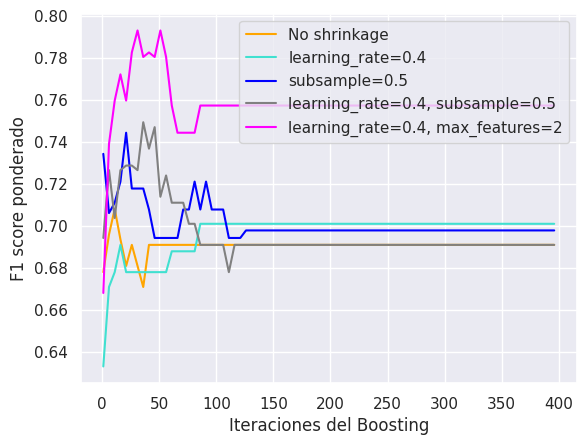

In [159]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

heart.columns = ['Edad','Anemia', 'Creatinina fosfocinasa', 'Diabetes','Fracción de eyección','Hipertensión', 'Plaquetas','Suero de creatinina','Sodio sérico','Sexo', 'Fumador', 'Tiempo', 'Fallecimiento']
labels =  np.unique(heart['Fallecimiento'])

original_params = {'n_estimators':  400, 'max_depth': 5}


plt.figure()

for label, color, setting in [
    ("No shrinkage", "orange", {"learning_rate": 1.0, "subsample": 1.0}),
    ("learning_rate=0.4", "turquoise", {"learning_rate": 0.4, "subsample": 1.0}),
    ("subsample=0.5", "blue", {"learning_rate": 1.0, "subsample": 0.5}),
    (
        "learning_rate=0.4, subsample=0.5",
        "gray",
        {"learning_rate": 0.4, "subsample": 0.5},
    ),
    (
        "learning_rate=0.4, max_features=2",
        "magenta",
        {"learning_rate": 0.4, "max_features": 2},
    ),
]:
    params = dict(original_params)
    params.update(setting)

    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    # compute test set deviance
    test_score = np.zeros((params["n_estimators"],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_predict(X_test)):

        test_score[i] = metrics.f1_score(y_test, y_pred, average='weighted')

    plt.plot(
        (np.arange(test_score.shape[0]) + 1)[::5],
        test_score[::5],
        "-",
        color=color,
        label=label,
    )

plt.legend(loc="upper right")
plt.xlabel("Iteraciones del Boosting")
plt.ylabel("F1 score ponderado")

plt.show()

In [160]:
from numpy.random.mtrand import rand
#Definimos los modelos con sus respectivos rangos de hiperparámetros
models = [
    {
        'model': DecisionTreeClassifier(),
        'params':{'criterion':['entropy', 'gini'],'splitter':['random','best'], 'min_weight_fraction_leaf':[0.0, 0.0025, 0.005, 0.0075,0.01],'min_samples_split':[2, 3, 4, 5, 6, 8, 10],
                  'min_samples_leaf':[1, 0.01, 0.02,0.03, 0.04],'min_impurity_decrease':[0.0, 0.0005, 0.005, 0.05, 0.10, 0.15,0.2],'max_leaf_nodes':[10, 15, 20, 25, 30, 35, 40, 45, 50, None],
                  'max_features':['auto', 0.95, 0.90, 0.85, 0.80, 0.75, 0.70],'max_depth':[None,2,4,6,8],'min_weight_fraction_leaf':[0.0, 0.0025, 0.005, 0.0075, 0.01, 0.05]}
    },
    {
        'model': AdaBoostClassifier(),
        'params': {'n_estimators': [50, 100, 200,300,400], 'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]}
    },
    {
        'model': GradientBoostingClassifier(),
        'params': {'n_estimators': [50, 100, 200,300,400], 'max_depth':[2, 3, 5, 6, 8], "learning_rate":[ 0.4], "max_features": [2]}
    },
    {
        'model': XGBClassifier(),
        'params': {'n_estimators': [50, 100, 200,300,400], 'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],'max_depth':[2, 3, 5, 6, 8],'gamma':[0, 0.1, 0.5, 1, 2, 5],'min_child_weight':[1, 2, 3, 4, 5]}
    },
    {
        'model': MLPClassifier(),
        'params':{'solver': ['sgd'], 'max_iter': [5000],'hidden_layer_sizes': [10,20,30,40,50], 'alpha': [0.001,0.01, 0.1, 1,5,10]}
    },
    # {
    #     'model': SVC(),
    #     #'params': {'C': [1, 10, 100], 'kernel': ['linear', 'rbf']}
    #     'params': [{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['linear']},
    #      {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']}]
    # },
    {
        'model': RandomForestClassifier(),
        'params': {'n_estimators': [50, 100, 200,300,400], 'max_depth': [2,3,4,6,8,10,20,32]}
    }
]

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

results = []
importance_col = {'Algoritmo':[]}
i=0
for model_info in models:
    model = model_info['model']
    params = model_info['params']

    grid_search = RandomizedSearchCV(model, params, cv=kf, scoring='f1_weighted', random_state=42)
    grid_search.fit(X_train, y_train)  # Utilizar características y variable objetivo por separado

    best_model = grid_search.best_estimator_

    scores = cross_val_score(best_model, X_test,y_test, cv=kf, scoring='f1_weighted')  #Utilizar características y variable objetivo por separado
    avg_f1 = scores.mean()

    fit_time_best = grid_search.cv_results_['mean_fit_time'][grid_search.best_index_]

    results.append({'Model': best_model.__class__.__name__, 'Valor F1 ponderado': avg_f1, 'Tiempo de ejecución': fit_time_best})

    print("Modelo:", best_model.__class__.__name__)
    print("Mejores parámetros:", grid_search.best_params_)
    print("Cross Validation f1_weighted: %0.2f" % avg_f1)
    print("Tiempo de ejecución: %.2f seconds" % round(fit_time_best, 5))

    if hasattr(best_model, 'feature_importances_'):
      importances = best_model.feature_importances_
      for feature_name, importance in zip(range(len(importances)), importances):
        print(f"Feature {feature_name}: Importance {importance}")

      importance_col['Algoritmo'].append({'Model':[], 'Importance':[]})
      importance_col['Algoritmo'][i]['Model'] =  best_model.__class__.__name__
      importance_col['Algoritmo'][i]['Importance'] =  importances
      i+=1
    print("\n")

#Creamos un dataframe con los resultados
heart_results = pd.DataFrame(results)

Modelo: DecisionTreeClassifier
Mejores parámetros: {'splitter': 'best', 'min_weight_fraction_leaf': 0.01, 'min_samples_split': 10, 'min_samples_leaf': 0.04, 'min_impurity_decrease': 0.1, 'max_leaf_nodes': 40, 'max_features': 0.8, 'max_depth': None, 'criterion': 'entropy'}
Cross Validation f1_weighted: 0.59
Tiempo de ejecución: 0.00 seconds
Feature 0: Importance 0.0
Feature 1: Importance 0.0
Feature 2: Importance 0.0
Feature 3: Importance 0.0
Feature 4: Importance 0.0
Feature 5: Importance 0.0
Feature 6: Importance 0.0
Feature 7: Importance 0.0
Feature 8: Importance 0.0
Feature 9: Importance 0.0
Feature 10: Importance 0.0
Feature 11: Importance 1.0


Modelo: AdaBoostClassifier
Mejores parámetros: {'n_estimators': 300, 'learning_rate': 0.05}
Cross Validation f1_weighted: 0.69
Tiempo de ejecución: 0.35 seconds
Feature 0: Importance 0.13666666666666666
Feature 1: Importance 0.0
Feature 2: Importance 0.19333333333333333
Feature 3: Importance 0.0
Feature 4: Importance 0.11
Feature 5: Importa

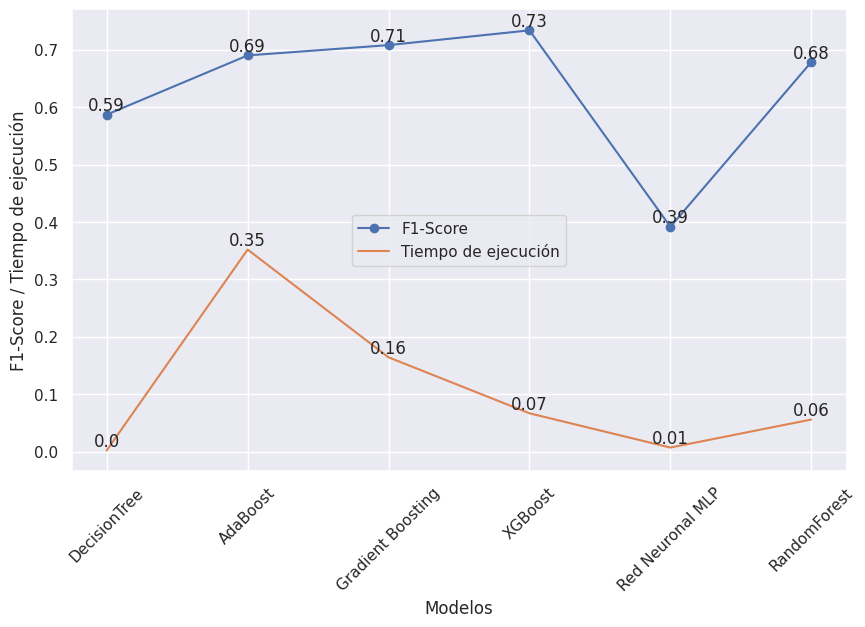

In [161]:
import numpy as np
import matplotlib.pyplot as plt

#Gráfico comparativo de precisión y tiempo de ejecución
models = ['DecisionTree','AdaBoost', 'Gradient Boosting', 'XGBoost', 'Red Neuronal MLP', 'RandomForest']
score_test = heart_results['Valor F1 ponderado']
execution_times = heart_results['Tiempo de ejecución']

#Escalamos los tiempos de ejecución para una mejor visualización en el gráfico
#scaled_execution_times = np.array(execution_times) / max(execution_times)

plt.figure(figsize=(10, 6))
plt.plot(models, score_test , marker='o', label='F1-Score')

for i in range(len(models)):
    plt.text(models[i], score_test [i], str(round(score_test[i],2)), ha='center', va='bottom')

plt.plot(models, execution_times, label='Tiempo de ejecución')

for i in range(len(models)):
    plt.text(models[i], execution_times[i], str(round(execution_times[i],2)), ha='center', va='bottom')

plt.xlabel('Modelos')
plt.ylabel('F1-Score / Tiempo de ejecución')
#plt.title('Desempeño y Tiempo de ejecución entre Modelos')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [162]:
importance_col['Algoritmo'][3]

{'Model': 'XGBClassifier',
 'Importance': array([0.07281101, 0.04083029, 0.07327639, 0.        , 0.07300337,
        0.        , 0.05259885, 0.1639523 , 0.05898085, 0.07272089,
        0.        , 0.39182606], dtype=float32)}

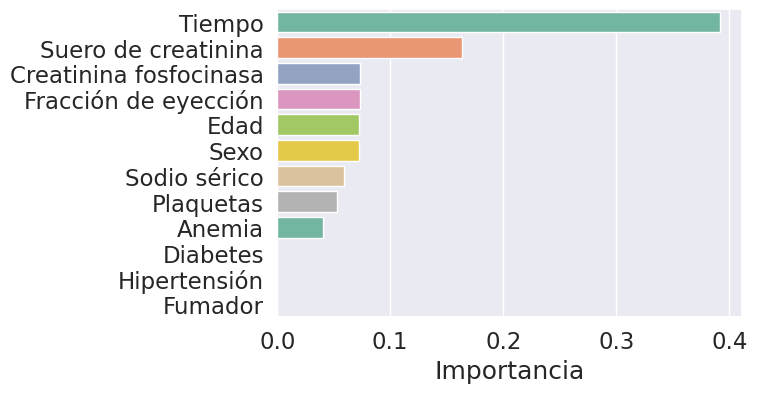

In [163]:
df = pd.DataFrame({ 'Variable': ['Edad','Anemia', 'Creatinina fosfocinasa', 'Diabetes', 'Fracción de eyección',
       'Hipertensión', 'Plaquetas', 'Suero de creatinina', 'Sodio sérico',
       'Sexo', 'Fumador', 'Tiempo'], 'Importancia': importance_col['Algoritmo'][3]['Importance']})

#sns.reset_defaults()
#sns.set_theme(style="whitegrid")
#sns.set_theme(style="ticks")
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(6, 4))
#pal = sns.color_palette("hls", 10)
g=sns.barplot(data= df.sort_values('Importancia',ascending=False), y='Variable', x="Importancia",ax=ax, palette="Set2")
g.set(xlabel ="Importancia", ylabel = "")
plt.show()
sns.set()